In [ ]:
##use the fc5 feature and ranking (total run)

In [4]:
import numpy as np
import os
import sys
import time
import argparse
import json
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
import torch
import torch.utils.data as data
import torch.optim as optim
from torch.autograd import Variable,Function
sys.path.insert(0,'/home/prisimage/tracker/py-MDNetST/modules')
from sample_generator import *
from data_prov import *
from model import *
from bbreg import *
from options import *
from gen_config import *
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist
def show_bbox(image,bboxes):
    dpi = 80.0
    figsize = (image.size[0]/dpi, image.size[1]/dpi)

    fig = plt.figure(frameon=False, figsize=figsize, dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    im = ax.imshow(image, aspect=1)
    for i in range(len(bboxes)):
        rect = plt.Rectangle(tuple(bboxes[i,:2]),bboxes[i,2],bboxes[i,3], 
                             linewidth=1, edgecolor="#ff0000", zorder=1, fill=False)
        ax.add_patch(rect)
def show_result(image,bbox):
    dpi = 80.0
    figsize = (image.size[0]/dpi, image.size[1]/dpi)

    fig = plt.figure(frameon=False, figsize=figsize, dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    im = ax.imshow(image, aspect=1)
    rect = plt.Rectangle(tuple(bbox[:2]),bbox[2],bbox[3], linewidth=1, edgecolor="#ff0000", zorder=1, fill=False)
    ax.add_patch(rect)
def show_grid(image,samples,num):
    image = np.asarray(image)
    sample_arr = list()
    image = np.asarray(image)
    for i in range(num):
        sample_img = crop_image(image,samples[i],107,0)
        sample_arr.append(sample_img)
    d = np.stack(sample_arr,axis=0)
    torch_img = torchvision.utils.make_grid(torch.from_numpy(np.transpose(d,(0,3,1,2))))
    npimg = torch_img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
def set_optimizer(model, lr_base, lr_mult=opts['lr_mult'], momentum=opts['momentum'], w_decay=opts['w_decay']):
    params = model.get_learnable_params()
    param_list = []
    for k, p in params.iteritems():
        lr = lr_base
        for l, m in lr_mult.iteritems():
            if k.startswith(l):
                lr = lr_base * m
        param_list.append({'params': [p], 'lr':lr})
    optimizer = optim.SGD(param_list, lr = lr, momentum=momentum, weight_decay=w_decay)
    return optimizer
def show_bbox(image,bboxes):
    dpi = 80.0
    figsize = (image.size[0]/dpi, image.size[1]/dpi)

    fig = plt.figure(frameon=False, figsize=figsize, dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    im = ax.imshow(image, aspect=1)
    for i in range(len(bboxes)):
        rect = plt.Rectangle(tuple(bboxes[i,:2]),bboxes[i,2],bboxes[i,3], 
                             linewidth=1, edgecolor="#ff0000", zorder=1, fill=False)
        ax.add_patch(rect)
def show_result(image,bbox):
    dpi = 80.0
    figsize = (image.size[0]/dpi, image.size[1]/dpi)

    fig = plt.figure(frameon=False, figsize=figsize, dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    im = ax.imshow(image, aspect=1)
    rect = plt.Rectangle(tuple(bbox[:2]),bbox[2],bbox[3], linewidth=1, edgecolor="#ff0000", zorder=1, fill=False)
    ax.add_patch(rect)
def forward_samples(model, image, samples, out_layer='conv3'):
    model.eval()
    extractor = RegionExtractor(image, samples, opts['img_size'], opts['padding'], opts['batch_test'])
    for i, regions in enumerate(extractor):
        regions = Variable(regions)
        if opts['use_gpu']:
            regions = regions.cuda()
        feat = model(regions, out_layer=out_layer)
        if i==0:
            feats = feat.data.clone()
        else:
            feats = torch.cat((feats,feat.data.clone()),0)
    return feats
def train(model, criterion, optimizer, pos_feats, neg_feats, maxiter, in_layer='fc4'):
    model.train()
    
    batch_pos = opts['batch_pos']
    batch_neg = opts['batch_neg']
    batch_test = opts['batch_test']
    batch_neg_cand = max(opts['batch_neg_cand'], batch_neg)

    pos_idx = np.random.permutation(pos_feats.size(0))
    neg_idx = np.random.permutation(neg_feats.size(0))
    while(len(pos_idx) < batch_pos*maxiter):
        pos_idx = np.concatenate([pos_idx, np.random.permutation(pos_feats.size(0))])
    while(len(neg_idx) < batch_neg_cand*maxiter):
        neg_idx = np.concatenate([neg_idx, np.random.permutation(neg_feats.size(0))])
    pos_pointer = 0
    neg_pointer = 0

    for iter in range(maxiter):

        # select pos idx
        pos_next = pos_pointer+batch_pos
        pos_cur_idx = pos_idx[pos_pointer:pos_next]
        pos_cur_idx = pos_feats.new(pos_cur_idx).long()
        pos_pointer = pos_next

        # select neg idx
        neg_next = neg_pointer+batch_neg_cand
        neg_cur_idx = neg_idx[neg_pointer:neg_next]
        neg_cur_idx = neg_feats.new(neg_cur_idx).long()
        neg_pointer = neg_next

        # create batch
        batch_pos_feats = Variable(pos_feats.index_select(0, pos_cur_idx))
        batch_neg_feats = Variable(neg_feats.index_select(0, neg_cur_idx))

        # hard negative mining
        if batch_neg_cand > batch_neg:
            model.eval()
            for start in range(0,batch_neg_cand,batch_test):
                end = min(start+batch_test,batch_neg_cand)
                score = model(batch_neg_feats[start:end], in_layer=in_layer)
                if start==0:
                    neg_cand_score = score.data[:,1].clone()
                else:
                    neg_cand_score = torch.cat((neg_cand_score, score.data[:,1].clone()),0)

            _, top_idx = neg_cand_score.topk(batch_neg)
            batch_neg_feats = batch_neg_feats.index_select(0, Variable(top_idx))
            model.train()
        
        # forward
        pos_score = model(batch_pos_feats, in_layer=in_layer)
        neg_score = model(batch_neg_feats, in_layer=in_layer)
        
        # optimize
        loss = criterion(pos_score, neg_score)
        model.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), opts['grad_clip'])
        optimizer.step()

        #print "Iter %d, Loss %.4f" % (iter, loss.data[0])
#import cv2
def cvshow(img):
    cv2.imshow("Image",img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    

        
def stackList(featList):
    nframes = len(featList)
    for start in range(nframes):
        if start == 0:
            pos_data = featList[start].data.clone()
        else:
            pos_data = torch.cat((pos_data,featList[start].data.clone()),0)
    return pos_data
np.random.seed(123)
torch.manual_seed(456)
torch.cuda.manual_seed(789)
seq_home = '../dataset/OTB'
save_home = '../result_fig'
result_home = '../result'
        
seq_name = 'Bolt2'
img_dir = os.path.join(seq_home, seq_name, 'img')
gt_path = os.path.join(seq_home, seq_name, 'groundtruth_rect.txt')

img_list = os.listdir(img_dir)
img_list.sort()
img_list = [os.path.join(img_dir,x) for x in img_list]

gt = np.loadtxt(gt_path,delimiter=',')
init_bbox = gt[0]
        
savefig_dir = os.path.join(save_home,seq_name)
result_dir = os.path.join(result_home,seq_name)
if not os.path.exists(result_dir):
    os.makedirs(result_dir)
result_path = os.path.join(result_dir,'result.json')
# get imglist,gt
target_bbox = np.array(init_bbox)
result = np.zeros((len(img_list),4))
result_bb = np.zeros((len(img_list),4))
result[0] = target_bbox
result_bb[0] = target_bbox
#init the first target box and result array
#os.environ['CUDA_VISIBLE_DEVICES'] = "1"
model = MDNet(opts['model_path'])
if opts['use_gpu']:
    model = model.cuda()
model.set_learnable_params(opts['ft_layers'])
#init model and set learnable layers
criterion = BinaryLoss()
init_optimizer = set_optimizer(model, opts['lr_init'])
update_optimizer = set_optimizer(model, opts['lr_update'])
image = Image.open(img_list[0]).convert('RGB')
bbreg_examples = gen_samples(SampleGenerator('uniform', image.size, 0.3, 1.5, 1.1),target_bbox, opts['n_bbreg'], opts['overlap_bbreg'], opts['scale_bbreg'])
bbreg_feats = forward_samples(model, image, bbreg_examples)
bbreg = BBRegressor(image.size)
bbreg.train(bbreg_feats, bbreg_examples, target_bbox)
#train bbreg
pos_examples = gen_samples(SampleGenerator('gaussian', image.size, 1.5, 1.2),target_bbox, opts['n_pos_init'], opts['overlap_pos_init'])
neg_examples = np.concatenate([
                    gen_samples(SampleGenerator('uniform', image.size, 1, 2, 1.1), 
                                target_bbox, opts['n_neg_init']//2, opts['overlap_neg_init']),
                    gen_samples(SampleGenerator('whole', image.size, 0, 1.2, 1.1),
                                target_bbox, opts['n_neg_init']//2, opts['overlap_neg_init'])])
neg_examples = np.random.permutation(neg_examples)
pos_feats = forward_samples(model, image, pos_examples)
neg_feats = forward_samples(model, image, neg_examples)
feat_dim = pos_feats.size(-1)
#get init pos/neg feats

/usr/local/lib/python2.7/dist-packages/torch/cuda/__init__.py:97: UserWarning: 
    Found GPU2 GeForce GT 740 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [5]:
pos_feats.size()

torch.Size([114, 4608])

In [6]:
train(model, criterion, init_optimizer,pos_feats, neg_feats, opts['maxiter_init'])
# Init sample generators
sample_generator = SampleGenerator('gaussian', image.size, 0.8, 1.1, valid=True)
pos_generator = SampleGenerator('gaussian', image.size, 0.1, 1.2)
neg_generator = SampleGenerator('uniform', image.size, 1.5, 1.2)

# Init pos/neg features for update
pos_feats_all = [pos_feats[:opts['n_pos_update']]]
neg_feats_all = [neg_feats[:opts['n_neg_update']]]


/home/prisimage/tracker/py-MDNetST/modules/model.py:157: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  pos_loss = -F.log_softmax(pos_score)[:,1]
/home/prisimage/tracker/py-MDNetST/modules/model.py:158: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  neg_loss = -F.log_softmax(neg_score-5)[:,0]


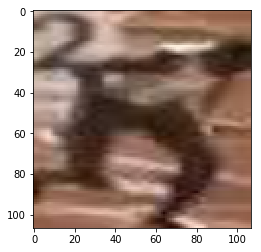

In [4]:
i=0
t_bbox = target_bbox[np.newaxis,:]
init_image = Image.open(img_list[0]).convert('RGB')
target_feat_fc5 = forward_samples(model,init_image,t_bbox,out_layer='fc5')
show_grid(init_image,t_bbox,1)

In [5]:
target_feat_fc5.size()

torch.Size([1, 512])

In [6]:
# iterating ........
i=i+1
image = Image.open(img_list[i]).convert('RGB')
# Estimate target bbox
samples = gen_samples(sample_generator, target_bbox, opts['n_samples'])
samples_feats_fc5 = forward_samples(model, image, samples,out_layer='fc5')
samples_feats_fc5 = samples_feats_fc5.cpu().numpy()
probFea = target_feat_fc5
galFea = samples_feats_fc5
query_num = probFea.shape[0]
all_num = query_num + galFea.shape[0]    

In [11]:
feat = np.append(probFea,galFea,axis = 0)

In [13]:
feat.size()

TypeError: 'int' object is not callable

0.05457

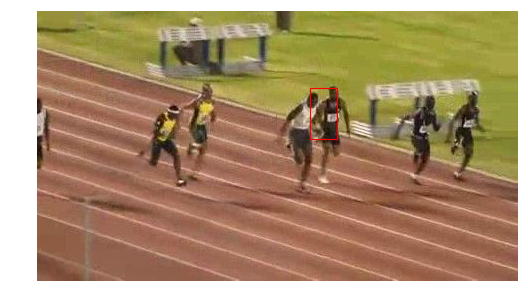

In [282]:
# iterating ........
i=i+1
image = Image.open(img_list[i]).convert('RGB')
# Estimate target bbox
samples = gen_samples(sample_generator, target_bbox, opts['n_samples'])
samples_feats_fc5 = forward_samples(model, image, samples,out_layer='fc5')
samples_feats_fc5 = samples_feats_fc5.cpu().numpy()
probFea = target_feat_fc5
galFea = samples_feats_fc5
query_num = probFea.shape[0]
all_num = query_num + galFea.shape[0]    
feat = np.append(probFea,galFea,axis = 0)
feat = feat.astype(np.float16)
original_dist = cdist(feat,feat).astype(np.float16)  
original_dist = np.power(original_dist,2).astype(np.float16)
del feat    
gallery_num = original_dist.shape[0]
original_dist = np.transpose(original_dist/np.max(original_dist,axis = 0))
V = np.zeros_like(original_dist).astype(np.float16)
initial_rank = np.argsort(original_dist).astype(np.int32)
samples = np.concatenate([t_bbox,samples],axis=0)
samples = samples[initial_rank[0,:],:]
target_bbox = samples[1:6,:].mean(axis=0)
show_result(image,target_bbox)
original_dist[initial_rank[0,1:6],0].mean()

In [3833]:
probFea = target_feat_fc5
galFea = samples_feats_fc5
query_num = probFea.shape[0]
all_num = query_num + galFea.shape[0]    
feat = np.append(probFea,galFea,axis = 0)
feat = feat.astype(np.float16)
original_dist = cdist(feat,feat).astype(np.float16)  
original_dist = np.power(original_dist,2).astype(np.float16)
del feat    
gallery_num = original_dist.shape[0]
original_dist = np.transpose(original_dist/np.max(original_dist,axis = 0))
V = np.zeros_like(original_dist).astype(np.float16)
initial_rank = np.argsort(original_dist).astype(np.int32)
samples = np.concatenate([t_bbox,samples],axis=0)
samples = samples[initial_rank[0,:],:]

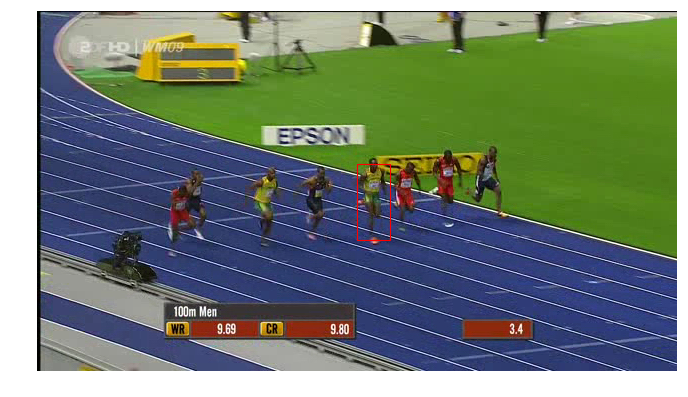

In [240]:
target_bbox = samples[1:6,:].mean(axis=0)
show_result(image,target_bbox)

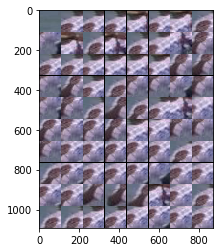

In [3988]:
show_grid(image,samples,80)

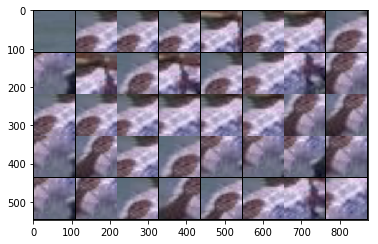

In [3989]:
show_grid(image,samples,40)

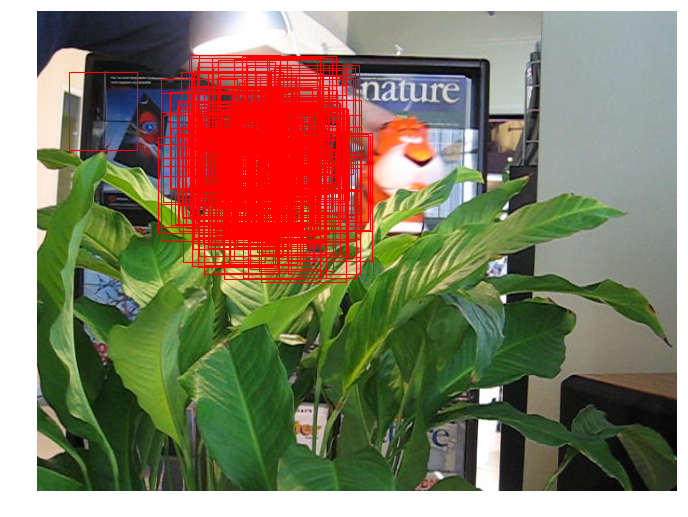

In [4758]:
show_bbox(image,samples[:,:])

In [2658]:
original_dist[initial_rank[0,:],0]

array([0.     , 0.02832, 0.0292 , 0.03372, 0.036  , 0.0356 , 0.03766,
       0.03934, 0.03818, 0.0457 , 0.0438 , 0.04764, 0.04974, 0.05264,
       0.0467 , 0.04935, 0.0532 , 0.04742, 0.04596, 0.04727, 0.0508 ,
       0.0529 , 0.0498 , 0.06238, 0.05447, 0.05667, 0.0619 , 0.0576 ,
       0.0574 , 0.0684 , 0.0668 , 0.0652 , 0.06445, 0.0588 , 0.05963,
       0.0608 , 0.07166, 0.06192, 0.05908, 0.06146, 0.06305, 0.0693 ,
       0.07745, 0.0682 , 0.07355, 0.05893, 0.06665, 0.08466, 0.0667 ,
       0.07526, 0.0771 , 0.07245, 0.0693 , 0.07404, 0.0674 , 0.06976,
       0.07153, 0.0791 , 0.07056, 0.0776 , 0.078  , 0.07904, 0.06946,
       0.0873 , 0.08386, 0.08685, 0.08203, 0.0869 , 0.08356, 0.0835 ,
       0.0941 , 0.0863 , 0.09094, 0.085  , 0.09216, 0.0759 , 0.08905,
       0.10767, 0.0973 , 0.09094, 0.0903 , 0.09235, 0.08746, 0.0873 ,
       0.0964 , 0.10114, 0.08246, 0.09186, 0.0938 , 0.1013 , 0.08923,
       0.0893 , 0.09924, 0.116  , 0.10126, 0.1025 , 0.10425, 0.0961 ,
       0.1263 , 0.11

In [ ]:
while True:
    # iterating ........
    i=i+1
    image = Image.open(img_list[i]).convert('RGB')
    # Estimate target bbox
    samples = gen_samples(sample_generator, target_bbox, opts['n_samples'])
    samples_feats_fc5 = forward_samples(model, image, samples,out_layer='fc5')
    samples_feats_fc5 = samples_feats_fc5.cpu().numpy()
    probFea = target_feat_fc5
    galFea = samples_feats_fc5
    query_num = probFea.shape[0]
    all_num = query_num + galFea.shape[0]    
    feat = np.append(probFea,galFea,axis = 0)
    feat = feat.astype(np.float16)
    original_dist = cdist(feat,feat).astype(np.float16)  
    original_dist = np.power(original_dist,2).astype(np.float16)
    del feat    
    gallery_num = original_dist.shape[0]
    original_dist = np.transpose(original_dist/np.max(original_dist,axis = 0))
    V = np.zeros_like(original_dist).astype(np.float16)
    initial_rank = np.argsort(original_dist).astype(np.int32)
    samples = np.concatenate([t_bbox,samples],axis=0)
    samples = samples[initial_rank[0,:],:]
    target_bbox = samples[1:6,:].mean(axis=0)
    show_result(image,target_bbox)
    original_dist[initial_rank[0,1:6],0].mean()

/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [7]:
        # forward
        pos_fc5 = model(pos_feats, in_layer='fc4',out_layer='fc5')
        neg_fc5 = model(neg_feats, in_layer='fc4',out_layer='fc5')

In [8]:
pdist = PairwiseDistance()

In [9]:
d_p = pdist.forward(pos_fc5,pos_fc5)
d_p

Variable containing:
 0.6762
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [10]:
d_n = pdist.forward(pos_fc5,neg_fc5)
d_n

Variable containing:
 0.2100
[torch.cuda.FloatTensor of size 1 (GPU 0)]